In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import datetime

In [2]:
def read_and_preprocess(path):
    archive = zipfile.ZipFile(path, 'r')
    file = archive.open("MetroPT3(AirCompressor).csv")
    df = pd.read_csv(file)
    df.drop("Unnamed: 0",axis=1,inplace=True)
    df["Failure"] = 0
    df.timestamp = pd.to_datetime(df.timestamp)
    df = df.set_index("timestamp")
    df.loc["2020-04-18 00:00:00":"2020-04-18 23:59:00","Failure"] = 1
    df.loc["2020-05-29 23:30:00":"2020-05-30 06:00:00","Failure"] = 1
    df.loc["2020-06-05 10:00:00":"2020-06-07 14:30:00","Failure"] = 1
    df.loc["2020-07-15 14:30:00":"2020-07-15 19:00:00","Failure"] = 1
    print("Reading and preprocess is successful!")
    return df

In [3]:
data = read_and_preprocess("data.zip")

Reading and preprocess is successful!


In [4]:
TARGET = "Failure"
FEATURES = data.drop(TARGET,axis=1).columns

In [5]:
binary_cols = []
non_binary_cols = []
for col in data.columns:
    if data[col].nunique() ==2:
        binary_cols.append(col)
        print(f"{col} unique values: {data[col].nunique()}")
    else:
        print(f"{col} unique values: {data[col].nunique()}")
        non_binary_cols.append(col)
    

TP2 unique values: 5257
TP3 unique values: 3683
H1 unique values: 2665
DV_pressure unique values: 2257
Reservoirs unique values: 3682
Oil_temperature unique values: 2462
Motor_current unique values: 1809
COMP unique values: 2
DV_eletric unique values: 2
Towers unique values: 2
MPG unique values: 2
LPS unique values: 2
Pressure_switch unique values: 2
Oil_level unique values: 2
Caudal_impulses unique values: 2
Failure unique values: 2


In [6]:
def visualize_timeseries(df,start_time,day_count:int,hour_count,col,save=False):
    '''
    day_count: number of days to add to the start time
    hour_count: number of hours to add to the start_time
    save: if True, saves the figure
    
    '''
    start_time = pd.to_datetime(start_time)
    end_time = start_time + datetime.timedelta(days=day_count,hours=hour_count)
    

    
    
    df_slice = df.loc[start_time:end_time]


    failure_data_idx = df_slice[df_slice["Failure"]==1].index
    non_failure_data_idx = df_slice[df_slice["Failure"]==0].index

    plt_name = f"{col} plot from {start_time} - {end_time}"
    plt.figure(figsize=(15,5))
    plt.title(plt_name)

    for idx in df_slice.index:
        if idx in failure_data_idx:
            plt.plot(idx,df_slice.loc[idx][col],"r.")
        elif idx in non_failure_data_idx:
            plt.plot(idx,df_slice.loc[idx][col],"b.")

    # plt.plot(failure_data_idx,df_slice.loc[failure_data_idx][col],"r-")
    # plt.plot(non_failure_data_idx,df_slice.loc[non_failure_data_idx][col],"b-")

    
    
    # sns.scatterplot(data=df_slice,x=df_slice.index,y=col,hue="Failure")
    if save:
        plt.savefig("plots/" + plt_name + ".png")
    
    plt.show()
    return None
    
    

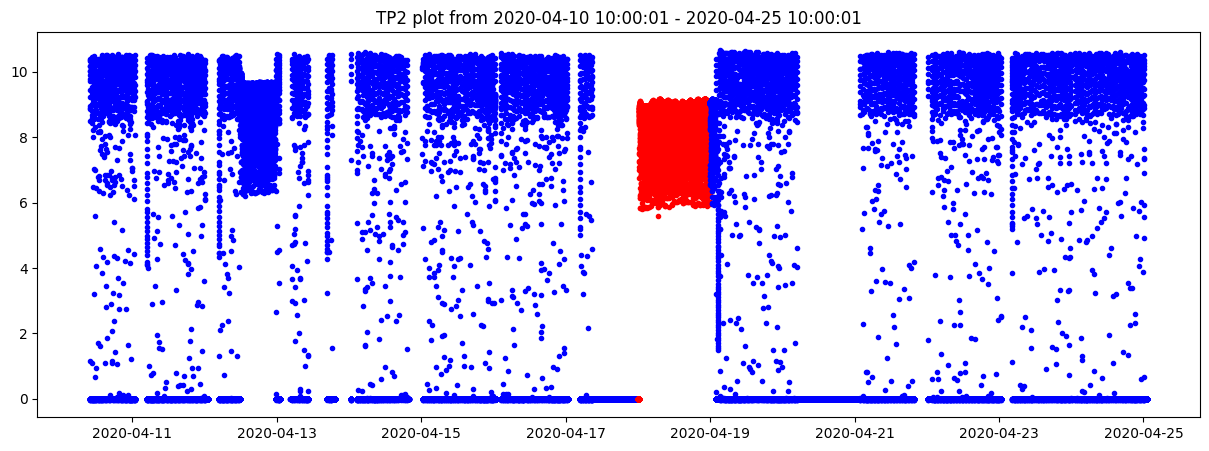

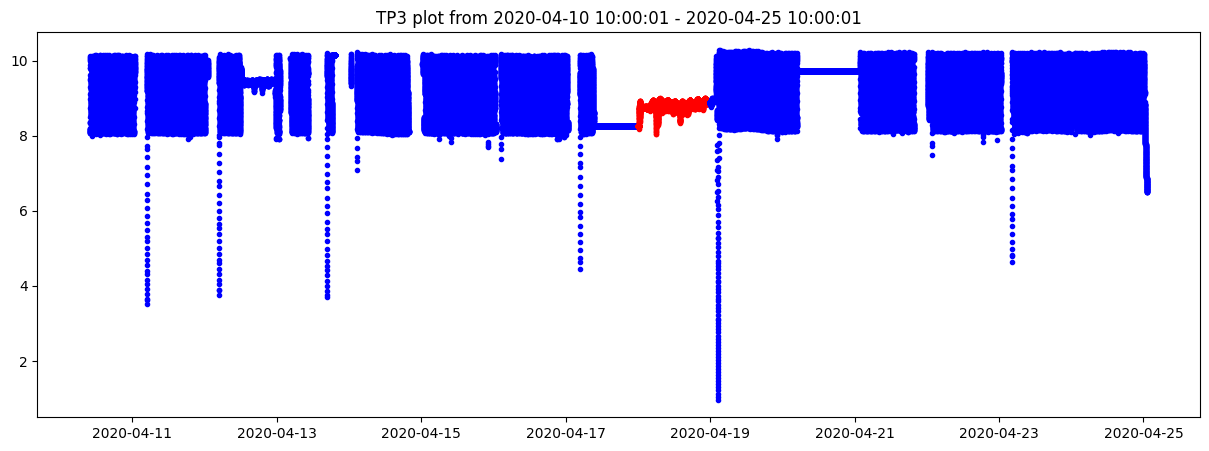

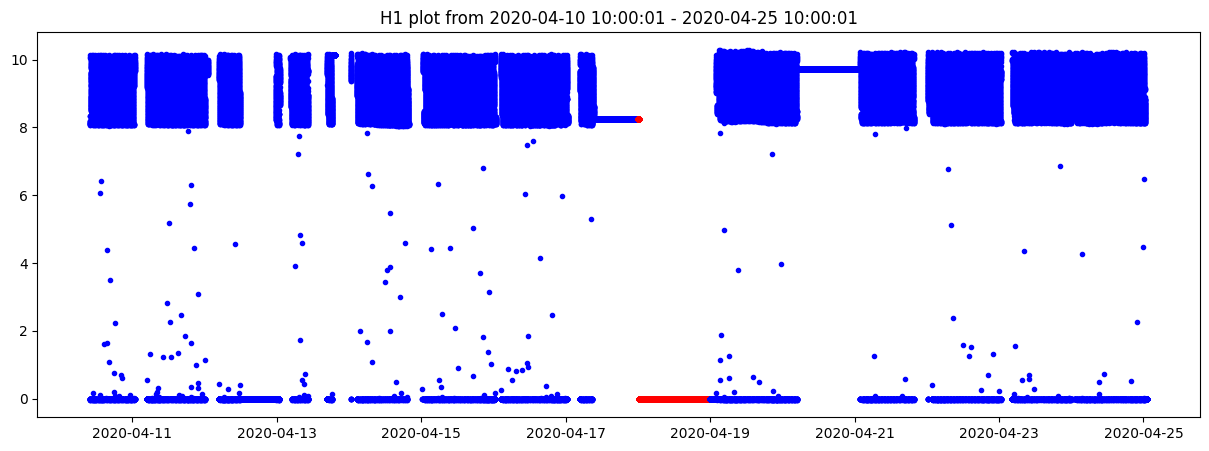

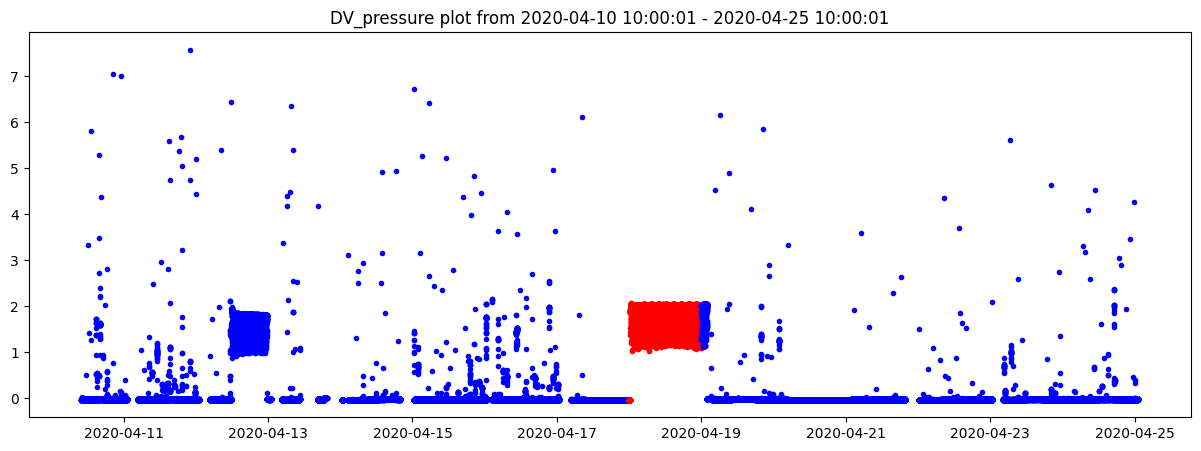

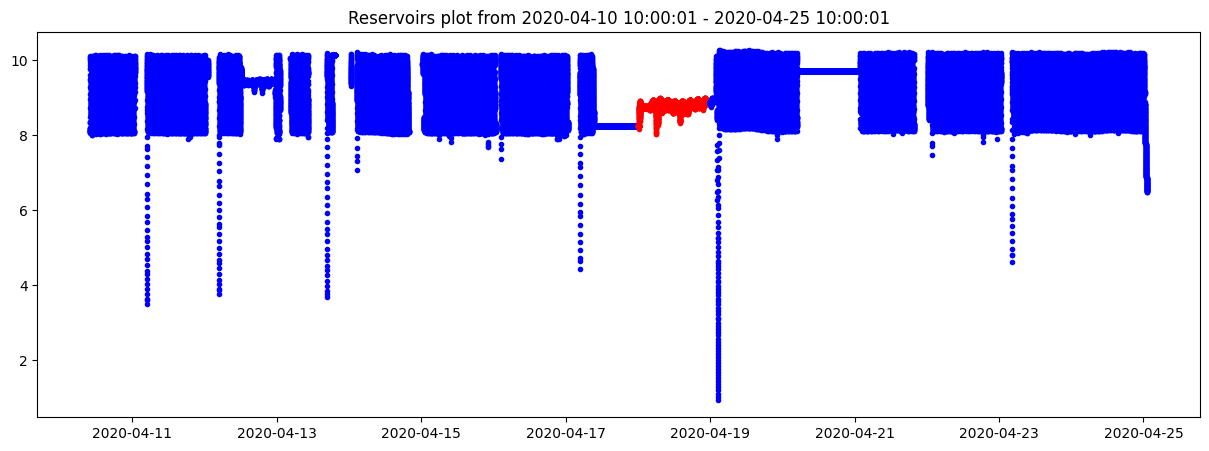

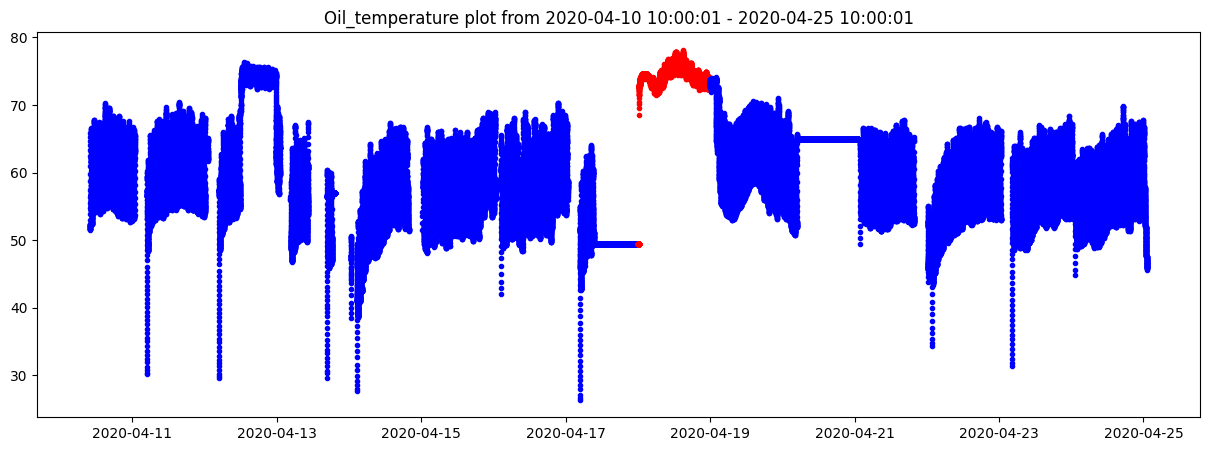

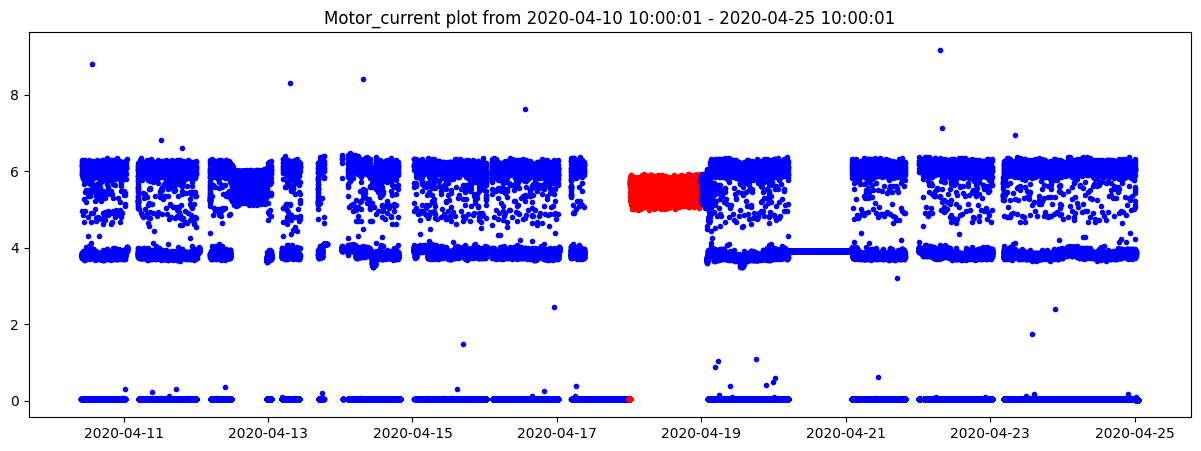

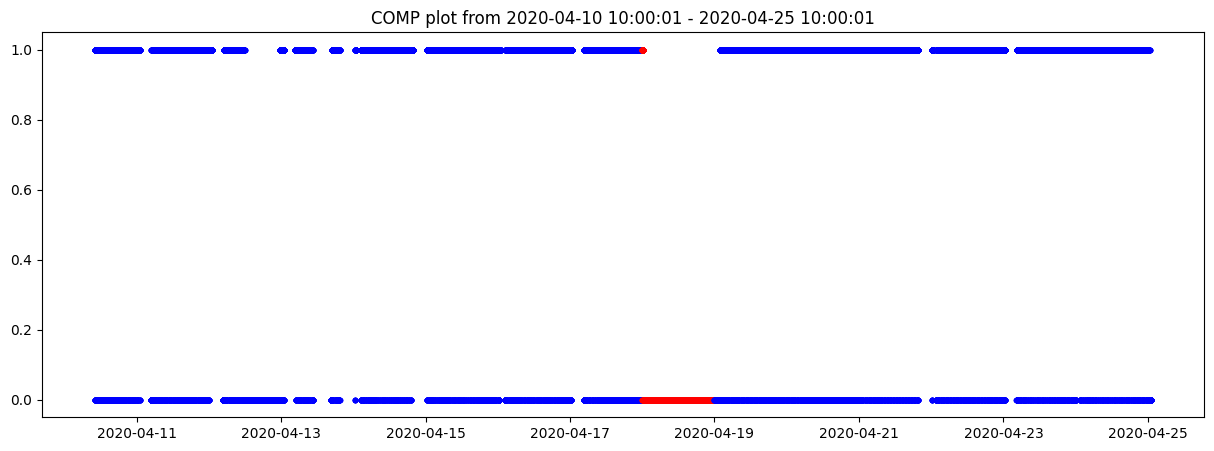

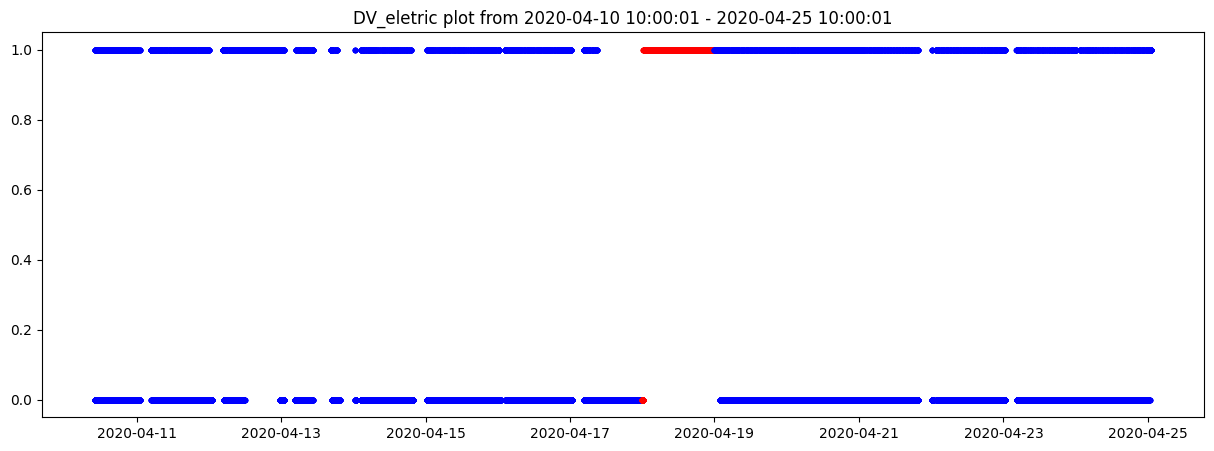

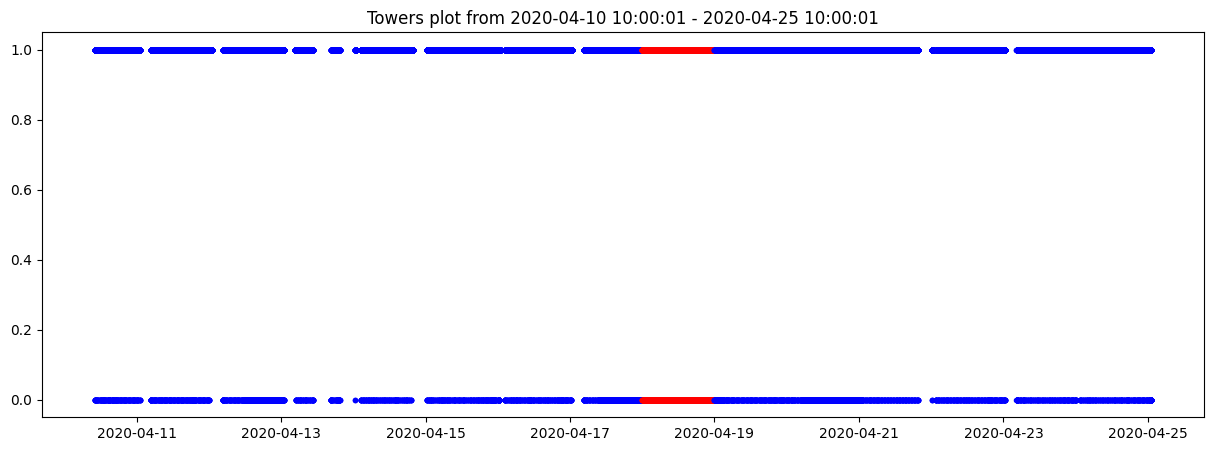

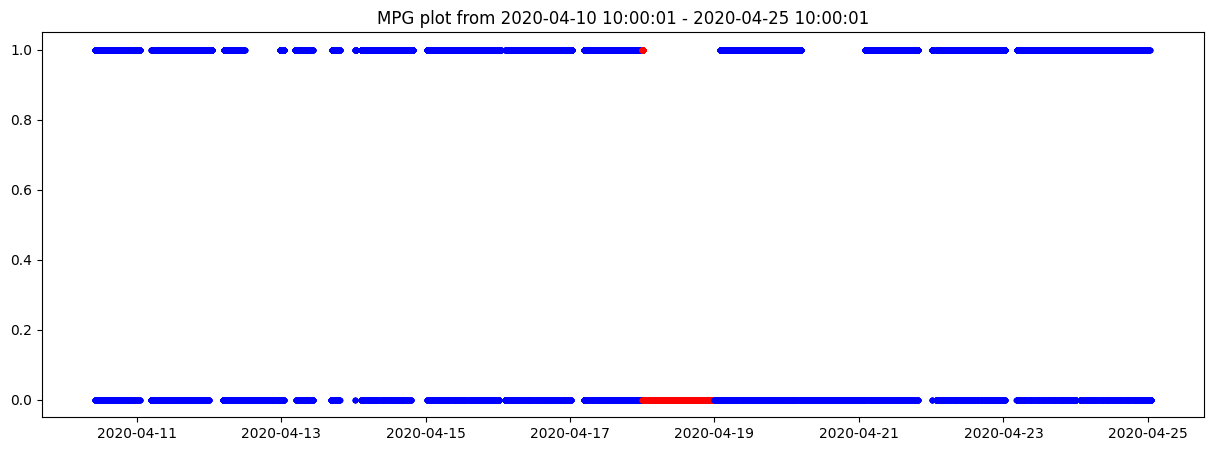

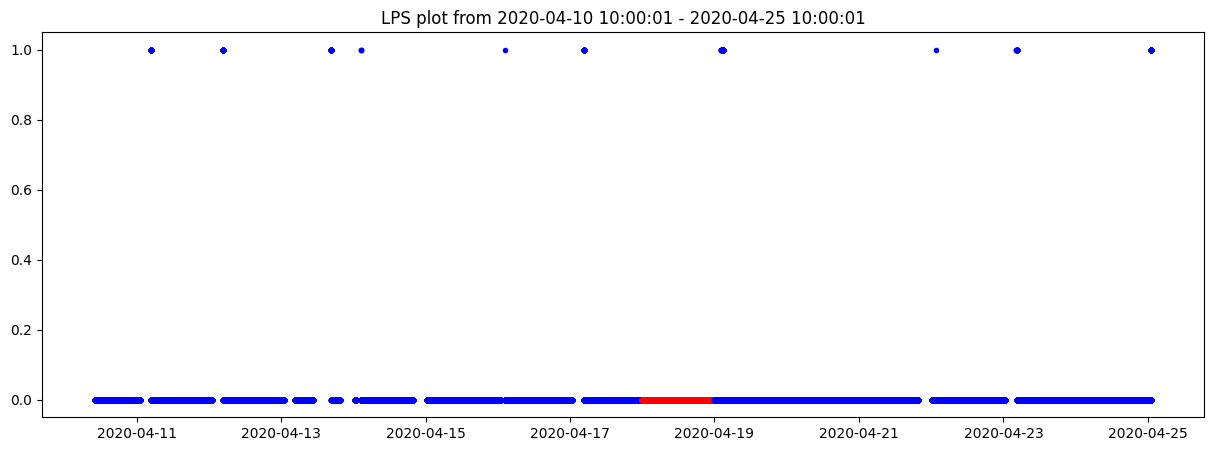

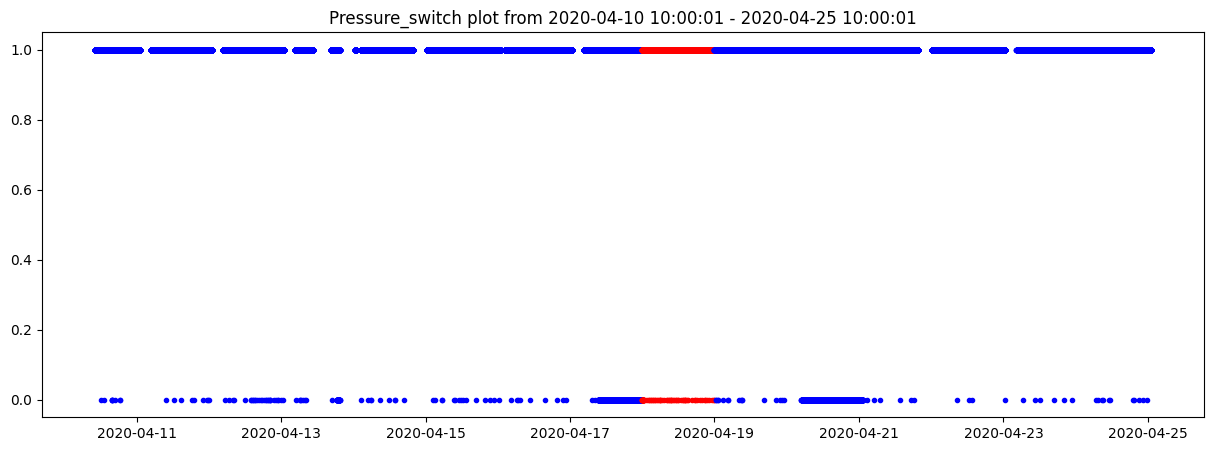

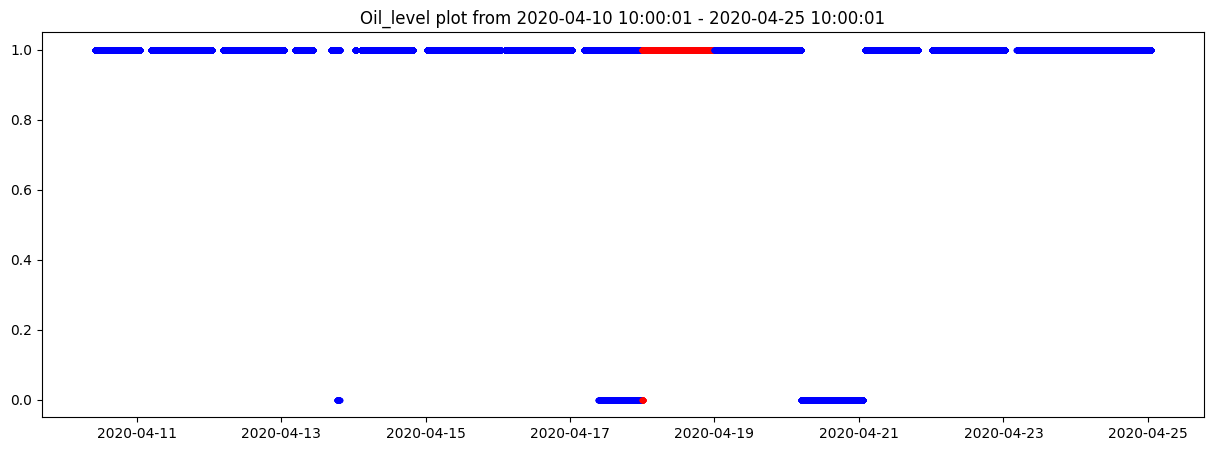

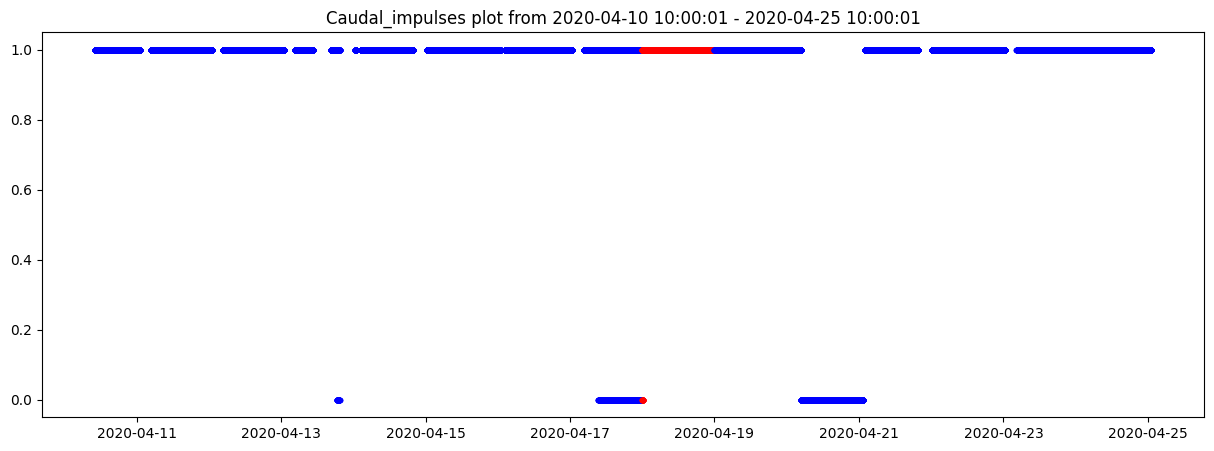

In [7]:
for col in FEATURES:
    visualize_timeseries(data,"2020-04-10 10:00:01",15,0,col,save=True)